In [2]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import time
import numpy as np

### Read in all parks dataframe

In [3]:
all_parks_df = pd.read_pickle("../../21_6_1/notebooks/all_parks_df.pkl")

In [4]:
all_parks_df.head()

,NAME,FEATTYPE,MNFC,SQMI,Shape_Leng,Shape_Area,geometry
0,Pago Pago Park,Local park,7170,0.02,0.010034,0.000005,"POLYGON ((-170.70291 -14.27240, -170.70316 -14..."
1,National Park of American Samoa,National park,7170,4.06,0.326497,0.000881,"MULTIPOLYGON (((-170.71479 -14.28528, -170.714..."
3,Hawaiian Islands National Wildlife Refuge,Regional park,7170,2.67,0.327720,0.000620,"MULTIPOLYGON (((-161.92806 23.05707, -161.9281..."
4,Russian Fort Elizabeth State Historical Park,State park,7170,0.03,0.010972,0.000006,"POLYGON ((-159.66526 21.94916, -159.66526 21.9..."
5,Waimea Recreation Pier Park,Local park,7170,0.01,0.004661,0.000001,"POLYGON ((-159.66955 21.95445, -159.66961 21.9..."


(array([1.0000e+00, 1.9000e+01, 1.3140e+03, 1.4736e+04, 1.7276e+04,
        5.3290e+03, 2.1970e+03, 4.6300e+02, 6.8000e+01, 2.2000e+01]),
 array([-13.67740216, -11.10196802,  -8.52653389,  -5.95109975,
         -3.37566562,  -0.80023149,   1.77520265,   4.35063678,
          6.92607092,   9.50150505,  12.07693918]),
 <BarContainer object of 10 artists>)

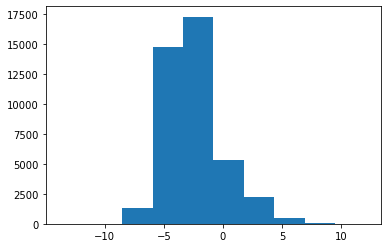

In [5]:
plt.hist(np.log(all_parks_df['Shape_Area']*10000))

In [40]:
all_parks_df = all_parks_df.to_crs(epsg = 6933)

In [41]:
all_parks_df["area (km sq)"] = all_parks_df['geometry'].area/ 10**6

### Read in POI CSV files and convert to geodataframes 

In [4]:
### read in the POI CSVs

In [23]:
dfs = {}

for i in tqdm([0,1,2,3,4]):
    df_name = f"poi_{i+1}"
    dfs[df_name] = pd.read_csv(f'../input_data/core_poi-part{i+1}.csv', encoding = 'latin1')

100%|██████████| 5/5 [00:33<00:00,  6.75s/it]


In [5]:
### convert each POI df to GDF and put in a set of GDFs

In [24]:
gdfs = {}

for i in tqdm([0,1,2,3,4]):
    gdf_name = f"poi_{i+1}_gdf"
    df = dfs[f"poi_{i+1}"]
    gdfs[gdf_name] = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))

100%|██████████| 5/5 [01:19<00:00, 15.92s/it]


In [25]:
type(gdfs["poi_1_gdf"])

geopandas.geodataframe.GeoDataFrame

### Spatial join between POI gdfs and all_parks to find which POIs fall within the boundaries of parks

In [7]:
points_within_1 = gpd.sjoin(gdfs["poi_1_gdf"] , all_parks_df, op='within')

In [27]:
points_within_2 = gpd.sjoin(gdfs["poi_2_gdf"] , all_parks_df, op='within')

In [28]:
points_within_3 = gpd.sjoin(gdfs["poi_3_gdf"] , all_parks_df, op='within')

In [29]:
points_within_4 = gpd.sjoin(gdfs["poi_4_gdf"] , all_parks_df, op='within')

In [30]:
points_within_5 = gpd.sjoin(gdfs["poi_5_gdf"] , all_parks_df, op='within')

In [31]:
all_points_within_df = pd.concat([points_within_1, points_within_2, points_within_3, points_within_4, points_within_5])

### Explore spatial join between all_parks and POI gdfs -- 

### Make final df grouped by park, so that for each park there is a featttype column, list of place POI ids that fall in the boundaries of that park, list of the POI points, and the number of POIs

In [8]:
### make a point column from lat/long

In [32]:
all_points_within_df['poi_point'] = list(zip(all_points_within_df['latitude'],all_points_within_df['longitude']))

In [10]:
### for each park, make a column for the list of POIs, number of POIs, and place ID

In [33]:
points_within_list_df = all_points_within_df.groupby('NAME')['poi_point'].apply(list).reset_index(name='poi_point_list')

In [34]:
points_within_list_df['num_poi'] = points_within_list_df['poi_point_list'].apply(lambda x: len(x))

In [35]:
park_ids_list_df = all_points_within_df.groupby('NAME')['safegraph_place_id'].apply(list).reset_index(name='id_list')

In [36]:
points_and_ids_df = park_ids_list_df.merge(points_within_list_df, how='inner', on='NAME')

In [37]:
points_within_parks_df = (all_parks_df[['NAME', 'FEATTYPE']].merge(points_and_ids_df, how='inner', on='NAME')
                                                            .sort_values('num_poi', ascending=False)
                                                            .reset_index(drop=True))

In [38]:
points_within_parks_df

,NAME,FEATTYPE,id_list,poi_point_list,num_poi
0,Adirondack Park,State park,"[sg:ff6701bae8994b94bf22dae510051681, sg:80943...","[(44.279539, -73.980577), (43.776927, -74.2614...",2474
1,Kodiak National Wildlife Refuge,National park,"[sg:ec13e80265ef4b6989f1fe2905188763, sg:8d41d...","[(57.790870999999996, -152.405307), (57.787818...",233
2,Catskill Park,State park,"[sg:65571ad2f7b54ab19d52625cfd767284, sg:fafa6...","[(42.200418, -74.19337800000001), (42.305681, ...",204
3,Yukon Delta National Wildlife Refuge,Regional park,"[sg:65481c0d2ed0456899117052810720b5, sg:a7fa9...","[(60.794488, -161.768617), (60.533051, -165.10...",168
4,Kaloko Honokohau National Historical Park,National park,"[sg:1e067d0e27b244768417082a746c1e90, sg:a83ff...","[(19.68432, -156.018516), (19.672991, -156.015...",158
...,...,...,...,...,...
28715,Blumberg Park,Local park,[sg:a546361618d8437fb8a9b1ec1b889914],"[(29.579283, -97.972852)]",1
28716,Marion City Park,Local park,[sg:05a679fe46374a2c9b52be63106e7304],"[(29.573371, -98.140771)]",1
28717,Cypress Bend Park,Local park,[sg:87d52095dcd7410aaf4d48e5b2ca271c],"[(29.711453000000002, -98.106381)]",1
28718,Governor Ireland Park,Local park,[sg:8d68b4ad3acc4f2abb8c319526b7b194],"[(29.550512, -98.000312)]",1


### For parks that have multiple POIs within their boundaries, split each of these POIs into separate rows 

In [1]:
### First concat all duplicates into lists and then expand into new rows

In [39]:
for col in ['NAME', 'FEATTYPE', 'num_poi']:
    points_within_parks_df[f'{col}_list'] = points_within_parks_df[col].apply(lambda x: [x])
    points_within_parks_df[f'all_{col}_list'] = points_within_parks_df[f'{col}_list'] * points_within_parks_df['num_poi']

In [40]:
points_within_parks_df.head()

,NAME,FEATTYPE,id_list,poi_point_list,num_poi,NAME_list,all_NAME_list,FEATTYPE_list,all_FEATTYPE_list,num_poi_list,all_num_poi_list
0,Adirondack Park,State park,"[sg:ff6701bae8994b94bf22dae510051681, sg:80943...","[(44.279539, -73.980577), (43.776927, -74.2614...",2474,[Adirondack Park],"[Adirondack Park, Adirondack Park, Adirondack ...",[State park],"[State park, State park, State park, State par...",[2474],"[2474, 2474, 2474, 2474, 2474, 2474, 2474, 247..."
1,Kodiak National Wildlife Refuge,National park,"[sg:ec13e80265ef4b6989f1fe2905188763, sg:8d41d...","[(57.790870999999996, -152.405307), (57.787818...",233,[Kodiak National Wildlife Refuge],"[Kodiak National Wildlife Refuge, Kodiak Natio...",[National park],"[National park, National park, National park, ...",[233],"[233, 233, 233, 233, 233, 233, 233, 233, 233, ..."
2,Catskill Park,State park,"[sg:65571ad2f7b54ab19d52625cfd767284, sg:fafa6...","[(42.200418, -74.19337800000001), (42.305681, ...",204,[Catskill Park],"[Catskill Park, Catskill Park, Catskill Park, ...",[State park],"[State park, State park, State park, State par...",[204],"[204, 204, 204, 204, 204, 204, 204, 204, 204, ..."
3,Yukon Delta National Wildlife Refuge,Regional park,"[sg:65481c0d2ed0456899117052810720b5, sg:a7fa9...","[(60.794488, -161.768617), (60.533051, -165.10...",168,[Yukon Delta National Wildlife Refuge],"[Yukon Delta National Wildlife Refuge, Yukon D...",[Regional park],"[Regional park, Regional park, Regional park, ...",[168],"[168, 168, 168, 168, 168, 168, 168, 168, 168, ..."
4,Kaloko Honokohau National Historical Park,National park,"[sg:1e067d0e27b244768417082a746c1e90, sg:a83ff...","[(19.68432, -156.018516), (19.672991, -156.015...",158,[Kaloko Honokohau National Historical Park],"[Kaloko Honokohau National Historical Park, Ka...",[National park],"[National park, National park, National park, ...",[158],"[158, 158, 158, 158, 158, 158, 158, 158, 158, ..."


### Create df from scratch to expand list columns 

In [42]:
out_df = pd.DataFrame()

In [43]:
out_df['park_name'] = list(points_within_parks_df['all_NAME_list'].explode())

In [44]:
out_df['feattype'] = list(points_within_parks_df['all_FEATTYPE_list'].explode())

In [45]:
out_df['poi_id'] = list(points_within_parks_df['id_list'].explode())

In [46]:
out_df['poi_point_within'] =  list(points_within_parks_df['poi_point_list'].explode())

In [47]:
out_df['total_poi_count'] =  list(points_within_parks_df['all_num_poi_list'].explode())

In [48]:
out_df.head()

,park_name,feattype,poi_id,poi_point_within,total_poi_count
0,Adirondack Park,State park,sg:ff6701bae8994b94bf22dae510051681,"(44.279539, -73.980577)",2474
1,Adirondack Park,State park,sg:8094327a02554e65afee6a24210f084c,"(43.776927, -74.261485)",2474
2,Adirondack Park,State park,sg:ab18bb41fbeb4091a86f1731ac75e84d,"(43.449052, -73.693711)",2474
3,Adirondack Park,State park,sg:4ba564561c954ecca134135a3b89f820,"(43.751492, -74.79486899999999)",2474
4,Adirondack Park,State park,sg:9e193c8c8447492fb05451e1412b8ff1,"(43.500546, -73.782147)",2474


In [83]:
len(out_df)

48137

In [45]:
all_parks_df.to_pickle('../../21_6_6_/notebooks/all_parks_df.pkl')

In [82]:
out_df.to_pickle('../../21_6_6_/notebooks/out_df.pkl')